Firstly, let's import all the data and libaries that we will need to use

In [147]:
import sys
import pickle
from pprint import pprint
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

In [148]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [149]:
# Define all the features

In [150]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                      'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
                      'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi',
                  'shared_receipt_with_poi']

We will now do some explorations on the dataset, to see if there are any outliers or missing values.

In [151]:
# Basic Exploration
print "Total number of observations: {}".format(len(data_dict))
print "Total number of features: {}".format(len(financial_features) + len(email_features))
print "Total number of poi: {}".format(str(sum(1 for x in data_dict.values() if x['poi'])))

Total number of observations: 146
Total number of features: 20
Total number of poi: 18


And how many missing values?

In [152]:
# find out if any features are having extremely large number of missing values
for feature in financial_features:
    print "{}: {}".format(feature, str(sum(1 for x in data_dict.values() if x[feature] == 'NaN')))

for feature in email_features:
    print "{}: {}".format(feature, str(sum(1 for x in data_dict.values() if x[feature] == 'NaN')))

print "{}: {}".format('poi', str(sum(1 for x in data_dict.values() if x['poi'] == 'NaN')))

salary: 51
deferral_payments: 107
total_payments: 21
loan_advances: 142
bonus: 64
restricted_stock_deferred: 128
deferred_income: 97
total_stock_value: 20
expenses: 51
exercised_stock_options: 44
other: 53
long_term_incentive: 80
restricted_stock: 36
director_fees: 129
to_messages: 60
email_address: 35
from_poi_to_this_person: 60
from_messages: 60
from_this_person_to_poi: 60
shared_receipt_with_poi: 60
poi: 0


We would also like to find out people who have no data at all

In [153]:
# We would also want to find out if any observations are missing all values and see if they are poi
person_with_no_data = []
for person in data_dict.keys():
    number_of_missing_fields = sum(1 for x in data_dict[person].values() if x == 'NaN')
    if number_of_missing_fields >= 19:
        person_with_no_data.append(person)
    if number_of_missing_fields >= 15:
        print "Number of missing fields for {}: {}. is_poi? {}".format(person, number_of_missing_fields,
                                                                   data_dict[person]['poi'])
        
pprint(person_with_no_data)

# For those that doesn't have any value in it (all features are missing value), we will remove them
# as it doesn't make sense to consider them as a "record"
for person in person_with_no_data:
    del data_dict[person]

Number of missing fields for LOWRY CHARLES P: 16. is_poi? False
Number of missing fields for WALTERS GARETH W: 15. is_poi? False
Number of missing fields for CHAN RONNIE: 16. is_poi? False
Number of missing fields for WODRASKA JOHN: 17. is_poi? False
Number of missing fields for URQUHART JOHN A: 16. is_poi? False
Number of missing fields for WHALEY DAVID A: 18. is_poi? False
Number of missing fields for MENDELSOHN JOHN: 16. is_poi? False
Number of missing fields for CLINE KENNETH W: 17. is_poi? False
Number of missing fields for WAKEHAM JOHN: 17. is_poi? False
Number of missing fields for DUNCAN JOHN H: 15. is_poi? False
Number of missing fields for LEMAISTRE CHARLES: 15. is_poi? False
Number of missing fields for WROBEL BRUCE: 18. is_poi? False
Number of missing fields for MEYER JEROME J: 16. is_poi? False
Number of missing fields for SCRIMSHAW MATTHEW: 17. is_poi? False
Number of missing fields for GATHMANN WILLIAM D: 16. is_poi? False
Number of missing fields for GILLIS JOHN: 17. is

We found that records with high number of missing fields are usually not poi, so we will create a new feature of number_of_missing_fields

In [154]:
for person in data_dict.keys():
    data_dict[person]['number_of_missing_fields'] = sum(1 for x in data_dict[person].values() if x == 'NaN')

Also, email_address doesn't seem to be related in anyway for predicting if someone is poi or not

In [155]:
email_features.remove('email_address')

# Data Distributions

For easier investigations on the fields, let's convert them into pandas data frame first.

In [156]:
features_list = ['poi'] + financial_features + email_features
features_list_without_label = financial_features + email_features

df = pd.DataFrame(data_dict.values())
df.head()

df.drop('email_address', axis=1, inplace=True)

In [157]:
for col in financial_features:
    df[col] = df[col].astype('float64')
    
for col in email_features:
    df[col] = df[col].astype('float64')


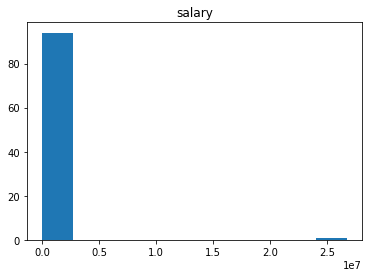

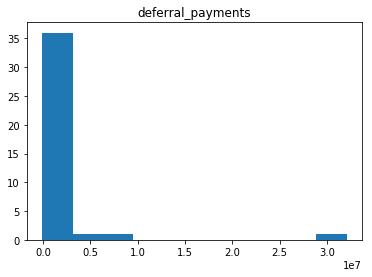

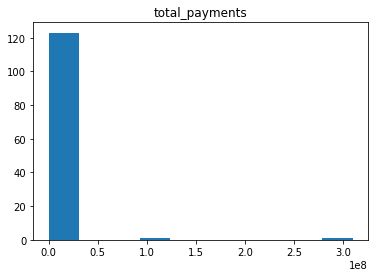

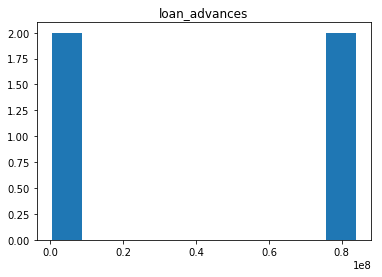

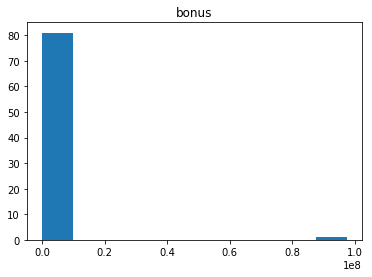

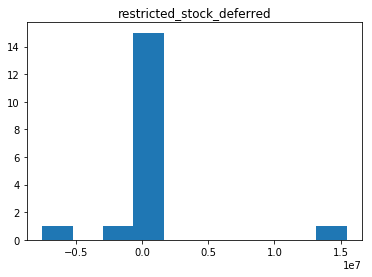

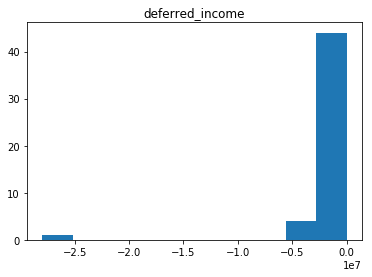

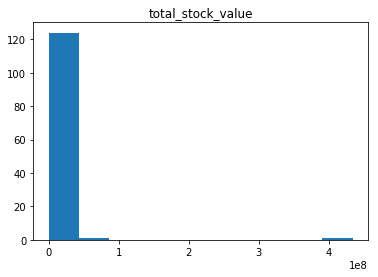

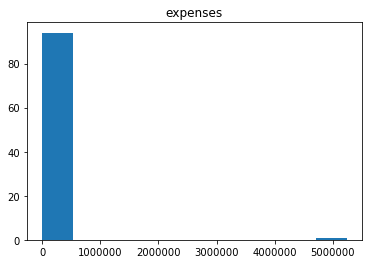

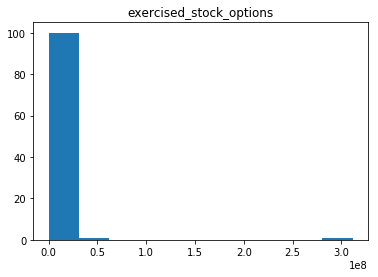

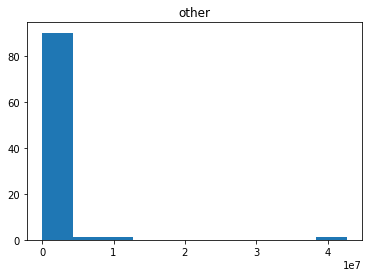

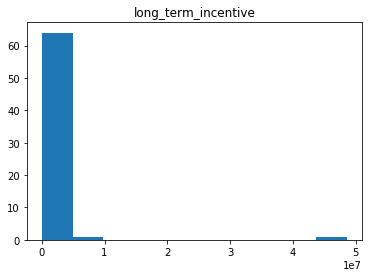

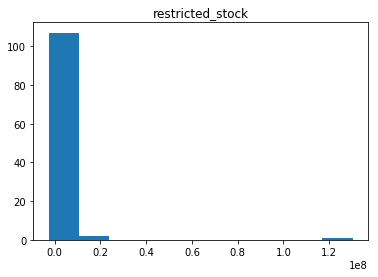

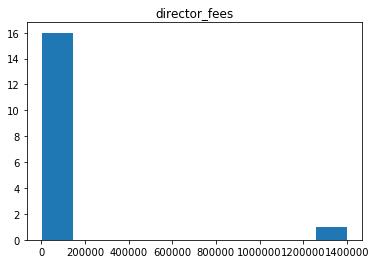

In [158]:
for idx, col in enumerate(financial_features):
    plt.figure(idx)
    plt.title(col)
    plt.hist(df[col].dropna())

We will try to remove the records of top 5% and bottom 5%. Let's try with salary field first.

In [159]:
person_with_extreme_value = set([])
for feature in ['salary']:
    upper = np.percentile(df[feature].dropna(), 95)
    lower = np.percentile(df[feature].dropna(), 5)
   
    for person in data_dict.keys():
        if data_dict[person][feature] != 'NaN':
            if data_dict[person][feature] >= upper:
                person_with_extreme_value.add(person)
            
            
print person_with_extreme_value
print len(person_with_extreme_value)

set(['FREVERT MARK A', 'SKILLING JEFFREY K', 'LAY KENNETH L', 'PICKERING MARK R', 'TOTAL'])
5


We found that there is a name as 'TOTAL'. This is the sum of all fields. So we will remove this entry before we do further outliers clean up.

In [160]:
del data_dict['TOTAL']

Then we can now do the outliers removal process for all fields

let's try to plot the historgram to see if there are still outliers

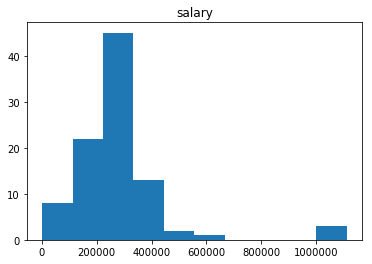

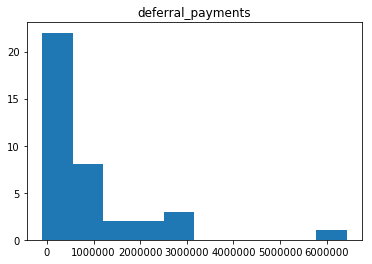

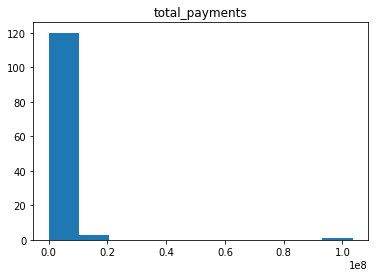

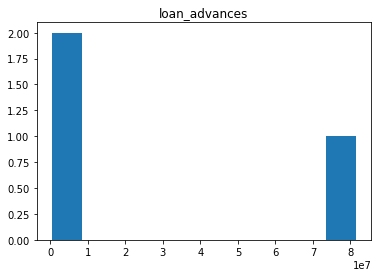

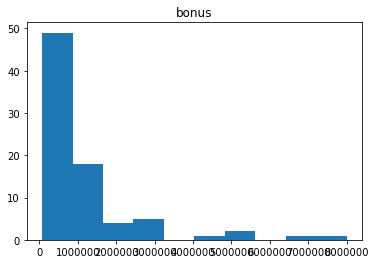

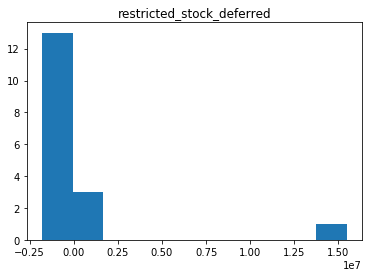

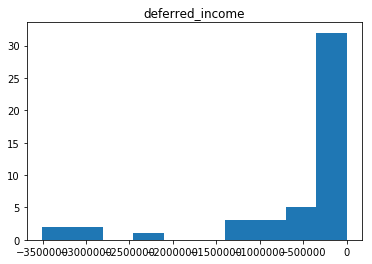

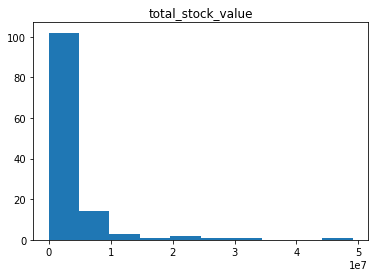

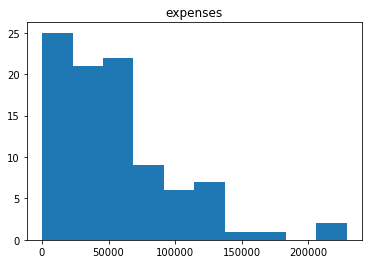

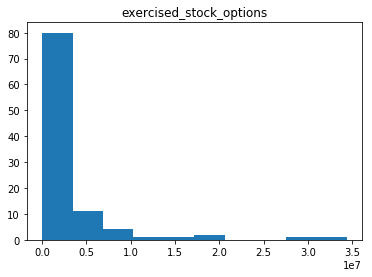

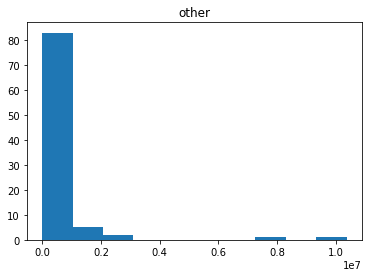

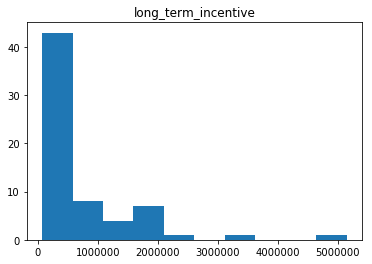

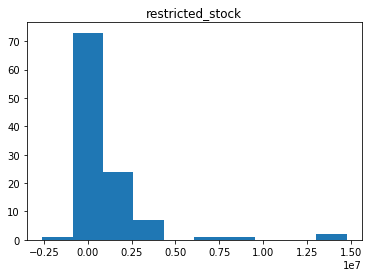

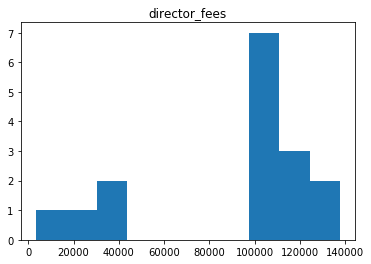

In [161]:
features_list = ['poi'] + financial_features + email_features
features_list_without_label = financial_features + email_features

df = pd.DataFrame(data_dict.values())
df.drop('email_address', axis=1, inplace=True)

for col in financial_features:
    df[col] = df[col].astype('float64')
    
for col in email_features:
    df[col] = df[col].astype('float64')

for idx, col in enumerate(financial_features):
    plt.figure(idx)
    plt.title(col)
    plt.hist(df[col].dropna())

A lot of fields are still having outliers, so we will remove the top and bottom 1 percent of records for now.

In [162]:
person_with_extreme_value = set([])
for feature in financial_features + email_features:
    upper = np.percentile(df[feature].dropna(), 98)
    lower = np.percentile(df[feature].dropna(), 2)
   
    for person in data_dict.keys():
        if data_dict[person][feature] != 'NaN':
            if data_dict[person][feature] >= upper or data_dict[person][feature] <= lower:
                person_with_extreme_value.add(person)
            
            
print person_with_extreme_value
print len(person_with_extreme_value)

for person in person_with_extreme_value:
    del data_dict[person]

set(['REYNOLDS LAWRENCE', 'WHITE JR THOMAS E', 'CORDES WILLIAM R', 'BOWEN JR RAYMOND M', 'RICE KENNETH D', 'HAYES ROBERT E', 'BUCHANAN HAROLD G', 'URQUHART JOHN A', 'MORAN MICHAEL P', 'LAVORATO JOHN J', 'JAEDICKE ROBERT', 'DURAN WILLIAM D', 'LEWIS RICHARD', 'POWERS WILLIAM', 'THORN TERENCE H', 'BANNANTINE JAMES M', 'DODSON KEITH', 'BHATNAGAR SANJAY', 'HIRKO JOSEPH', 'SHAPIRO RICHARD S', 'MULLER MARK S', 'DIETRICH JANET R', 'DERRICK JR. JAMES V', 'FREVERT MARK A', 'GILLIS JOHN', 'DEFFNER JOSEPH M', 'KAMINSKI WINCENTY J', 'WALLS JR ROBERT H', 'PAI LOU L', 'CHAN RONNIE', 'BELFER ROBERT', 'BERGSIEKER RICHARD P', 'BAY FRANKLIN R', 'SKILLING JEFFREY K', 'BLAKE JR. NORMAN P', 'PIRO JIM', 'DELAINEY DAVID W', 'MEYER ROCKFORD G', 'SULLIVAN-SHAKLOVITZ COLLEEN', 'GRAY RODNEY', 'COX DAVID', 'UMANOFF ADAM S', 'FOY JOE', 'FOWLER PEGGY', 'KEAN STEVEN J', 'LAY KENNETH L', 'MARTIN AMANDA K', 'HAUG DAVID L', 'PICKERING MARK R', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'GLISAN JR BEN F', 'GIBBS DANA R', 'TA

In [163]:
print len(data_dict)

88


Now quickly check on the distribution of the poi

In [164]:
print "Total number of poi: {}".format(str(sum(1 for x in data_dict.values() if x['poi'])))

Total number of poi: 10


And do feature scaling before we proceed

In [165]:
# convert the fields we want into numbers
for person in data_dict:
    for feature in ['salary']:
        if data_dict[person][feature] == "NaN":
            data_dict[person][feature] = 0
        else:
            data_dict[person][feature] = float(data_dict[person][feature])

# feature scaling
for feature in ['salary']:
    feature_max = max(x[feature] for x in data_dict.values())
    feature_min = min(x[feature] for x in data_dict.values())
    
    print feature
    print feature_max
    print feature_min
    for person in data_dict:
        data_dict[person][feature] = (data_dict[person][feature] - feature_min) / (feature_max - feature_min)

salary
510364.0
0


And prepare for the data format that sklearn will use

In [166]:
### Extract features and labels from dataset for local testing
my_dataset = data_dict
features_list = ['poi'] + financial_features + email_features
data = featureFormat(my_dataset, features_list, sort_keys=False)
labels, features = targetFeatureSplit(data)


First break into training set and test set

In [167]:
from sklearn.cross_validation import train_test_split

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [170]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, 10)
selector.fit(features_train, labels_train)
print selector.get_support(indices=True)
print np.array(features_list_without_label)[selector.get_support()]
print selector.scores_

[ 0  1  4  5  6  7 10 11 12 18]
['salary' 'deferral_payments' 'bonus' 'restricted_stock_deferred'
 'deferred_income' 'total_stock_value' 'other' 'long_term_incentive'
 'restricted_stock' 'shared_receipt_with_poi']
[  7.45236525e+00   4.75602337e-01   4.29406936e-01              nan
   2.78461663e+00   5.43659536e-01   1.86046793e+01   1.06531906e+00
   3.68113221e-01   2.88181693e-01   1.70449705e+00   5.22216032e+00
   2.78292632e+00   4.28060935e-01   2.33605808e-03   1.75528416e-02
   4.64871144e-01   3.41524062e-02   5.44130522e-01]


And now update the features_list

In [45]:
features_list = np.array(features_list_without_label)[selector.get_support()]

Try to do some random testing with three different models

In [46]:
from sklearn.naive_bayes import GaussianNB
gaussian_clf = GaussianNB()

from sklearn import tree
tree_clf = tree.DecisionTreeClassifier(min_samples_split=10)

from sklearn.svm import SVC
svm_clf =  SVC(kernel = 'rbf', C=10000)

gaussian_clf.fit(features_train, labels_train)
print gaussian_clf.score(features_test, labels_test)

tree_clf.fit(features_train, labels_train)
print tree_clf.score(features_test, labels_test)

svm_clf.fit(features_train, labels_train)
print svm_clf.score(features_test, labels_test)

0.518518518519
0.740740740741
0.814814814815


After trying out with the testing, we are still a bit low in terms of precision. Let's try to use GridSearchCV to tune the parameter of svm

In [ ]:
from sklearn import grid_search

# for svm
parameters = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'C': np.arange(1000, 100000, 1000)}
svr = SVC()
clf = model_selection.GridSearchCV(svr, parameters, scoring='precision', n_jobs=2, verbose=5)
clf.fit(features_train, labels_train)
print clf.best_params_
print clf.best_score_


# for decision tree
parameters = {
    'criterion': ('gini', 'entropy'),
    'splitter': ('best', 'random'),
    'max_features': np.arange(1, 5, 1),
    'max_depth': np.arange(1, 10, 1),
    'min_samples_split': np.arange(2, 40, 1),
}

tree = tree.DecisionTreeClassifier()
clf = model_selection.GridSearchCV(tree, parameters, scoring='precision', n_jobs=2, verbose=5)
clf.fit(features_train, labels_train)
print clf.best_params_
print clf.best_score_

but still it doesn't really work well, even I vaired the number of features. So I started suspecting about the feature selection step. And found that SelectKBest actually assumes that all the features are independent, which I don't think that's the case.

So I will try using tree-based feature selection

In [185]:
from sklearn.ensemble import ExtraTreesClassifier

features_list = ['poi'] + financial_features + email_features
data = featureFormat(my_dataset, features_list, sort_keys=False)
labels, features = targetFeatureSplit(data)

actual_features = financial_features + email_features

clf = ExtraTreesClassifier()
clf = clf.fit(features, labels)
print clf.feature_importances_  

df = pd.DataFrame({'features':actual_features, 'score':clf.feature_importances_})
df.sort_values(by = 'score', ascending=False)

[ 0.09378316  0.00727028  0.08253392  0.          0.08485595  0.00365928
  0.1053662   0.06663693  0.04229444  0.08083879  0.06058787  0.06027904
  0.10183934  0.          0.04043     0.04219022  0.03974183  0.05614666
  0.03154608]


,features,score
6,deferred_income,0.105366
12,restricted_stock,0.101839
0,salary,0.093783
4,bonus,0.084856
2,total_payments,0.082534
9,exercised_stock_options,0.080839
7,total_stock_value,0.066637
10,other,0.060588
11,long_term_incentive,0.060279
17,from_this_person_to_poi,0.056147


But still the precision is a bit low. So I will now try to handpick the features. It's very reasonable to think that to_messages and from_messages doesn't really related to the poi. It's more about if someone is busy within the company. But the relationship with poi is definitely important, so we will choose `from_this_person_to_poi` and `from_poi_to_this_person` and `shared_receipt_with_poi`.

So we will try with these 3 fields and restart with the model tuning.

After going through similar GridSearchCV process as above, we found that for these 3 features, the best setup:

For Decision tree is 

`{'max_features': 2, 'min_samples_split': 3, 'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}`

For SVM is
`{'kernel': 'rbf', 'C': 42000}`

And the precision score:

For Decision tree:
0.31790

For SVM:
~0.41795 

For Gaussian Classifier:
Precision: 0.30114 

As I have created a new feature, `number_of_missing_fields`, so I tried also putting that into the SVM and see if that helps.

After parameter tuning with GridSearchCV, the best setting is {'kernel': 'rbf', 'C': 21000} and the precision increate to 0.51985.

We will stop here for this project's purpose and choose the model with the following setup as final model as submission:

SVM:
`{'kernel': 'rbf', 'C': 21000}`

Features:
from_this_person_to_poi, from_poi_to_this_person, shared_receipt_with_poi, number_of_missing_fields